# DJ Spotify
## Combining Spotify, machine learning, and Alexa for an AI with your music taste
***
### By: Chris Gomez

### Table of Contents

1. [Spotipy](#spotipy)
2. [Data](#data)
    3. [Data Analysis](#analysis)
    4. [Data Modeling](#modeling)
5. [Classifiers and Model Training](#classifiers)
    6. [Decision Tree](#dt)
    7. [K-Neighbors](#knn)
    8. [Gaussian Process](#gauss)
    9. [Gaussian Naive Bayes](#bayes)
    10. [Ensemble Methods](#ensemble)
        11. [Bagging](#bagging)
        12. [Random Forest](#rf)
        13. [Extremly Randomized Trees](#et)
        14. [Ada Boost](#ab)
        15. [Gradient Tree Boosting](#gb)
    16. [Support Vector Machine](#svm)
    17. [Quadratic Discriminant Analysis](#qda)
    18. [Clusterings](#cluster)
    19. [Multi-layer Perceptron](#mlp)
    20. [Results](#res)
21. [Testing](#test)
22. [Conclusion](#conc)


#### Imports
***
Let's just get this out of the way first for some cleaner code cells.

In [122]:
import spotipy
import spotipy.util as util

import numpy as np
import io
from scipy import misc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz
import pydotplus

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<a id=spotipy></a>

### 1. Spotipy
***
I'll begin by setting up a python wrapper for the Spotify API and authenticating the app. The object returned by the cell will be used to call the API endpoints and analyze my listening habits.


In [172]:
# Please don't use my CID/Secret
cid ="" 
secret = ""
username = ""

# I want to read my library and playlists
scope = 'playlist-modify-private playlist-modify-public playlist-read-private user-library-read'

# Authtoken, standard authorization flow
token = util.prompt_for_user_token(username=username, scope=scope, client_id=cid, client_secret=secret,redirect_uri='http://localhost:8888')

if token:
    # Create the spotify API request object
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for ", username)

<a id='data'></a>

### 2. Data
***
Then, I start collecting songs from two different playlists I've created, one playlist full of songs I like and one playlist full of songs I hate, then analyze them for similarities, differences, and information.

In [151]:
# Let's begin with the good playlist
good_playlist = sp.user_playlist("123304145", "2pbZxAfbYWDabaRNUvBRBz")

# Get the tracks object, that's filled with items that are the actual songs
good_tracks = good_playlist["tracks"]
good_songs = good_tracks["items"]

# Spotify doesn't return more than 50 tracks at once, put they provide a paging object to get to the next 50 called
# 'next' so while next continue appending more songs
while good_tracks['next']:
    good_tracks = sp.next(good_tracks)
    for item in good_tracks["items"]:
        good_songs.append(item)

# Get the id's so I can use them in a search later
good_ids = [] 
for i in range(len(good_songs)):
    good_ids.append(good_songs[i]['track']['id'])

In [152]:
# Next the bad playlist
bad_playlist = sp.user_playlist("123304145", "376wtUAq4wcL7fkn5PvsXE")

bad_tracks = bad_playlist["tracks"]
bad_songs = bad_tracks["items"]

while bad_tracks['next']:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks["items"]:
        bad_songs.append(item)
        
bad_ids = [] 
for i in range(len(bad_songs)):
    bad_ids.append(bad_songs[i]['track']['id'])

<a id='anaylsis'></a>

#### 2a. Analysis
***
Now that I've gathered all the data, it's time to perform some analysis on it. Spotify provides an "Audio Features" object for every song. This object returns information about the song that can be used to analyze, look for patterns, likes and dislikes.

In [153]:
# First the good songs
features = []
j = 0

# Again, Spotify only returns 50 results at a time, so I'll have to split the songs into groups of 50 and 
# get the features in batches.
for i in range(0,len(good_ids),50):
    audio_features = sp.audio_features(good_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        # Since all the songs features' will be going in the same array we'll mark the difference with 1 || 0
        features[-1]['target'] = 1

In [154]:
# Now the bad songs
j = 0
for i in range(0,len(bad_ids),50):
    audio_features = sp.audio_features(bad_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['target'] = 0

<a id='modeling'></a>

#### 2b) Modeling
***
To analyze and get a better idea of the data and it's qualities, it's always a good idea to model it with some tables, charts and graphs.

In [155]:
# Place all the data in a pandas DataFrame to get a better picture of what it looks like
trainingData = pd.DataFrame(features)

# Here's the first 5 tracks in the list and their qualities and attributes found through the Audio Analysis
trainingData.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,target,tempo,time_signature,trackPopularity,track_href,type,uri,valence
0,0.0876,https://api.spotify.com/v1/audio-analysis/4keA...,0.430,145893,0.771,4keAoywVf4jxRvXU7ON0hV,0.023900,5,0.1210,-7.176,1,0.0375,1,201.001,4,67,https://api.spotify.com/v1/tracks/4keAoywVf4jx...,audio_features,spotify:track:4keAoywVf4jxRvXU7ON0hV,0.772
1,0.3910,https://api.spotify.com/v1/audio-analysis/5KQr...,0.656,210747,0.677,5KQrOv9nFVnM465CVGriW9,0.000002,2,0.1180,-6.929,1,0.0285,1,112.010,4,4,https://api.spotify.com/v1/tracks/5KQrOv9nFVnM...,audio_features,spotify:track:5KQrOv9nFVnM465CVGriW9,0.570
2,0.0851,https://api.spotify.com/v1/audio-analysis/2I43...,0.583,171333,0.790,2I43coEbzFSTMGO3kCjLMB,0.000387,9,0.1100,-4.885,1,0.0319,1,103.286,4,23,https://api.spotify.com/v1/tracks/2I43coEbzFST...,audio_features,spotify:track:2I43coEbzFSTMGO3kCjLMB,0.714
3,0.2920,https://api.spotify.com/v1/audio-analysis/6Zap...,0.542,303200,0.589,6ZapsNk1ZpaebNXAIohP9R,0.000522,2,0.1770,-6.623,1,0.0318,1,111.665,4,31,https://api.spotify.com/v1/tracks/6ZapsNk1Zpae...,audio_features,spotify:track:6ZapsNk1ZpaebNXAIohP9R,0.137
4,0.0191,https://api.spotify.com/v1/audio-analysis/36lq...,0.521,243960,0.752,36lqt57OHqk48BVFzPDEKt,0.000000,11,0.0682,-5.374,0,0.0369,1,105.051,4,9,https://api.spotify.com/v1/tracks/36lqt57OHqk4...,audio_features,spotify:track:36lqt57OHqk48BVFzPDEKt,0.300


Now lets split the data up into easy to plot data points.

In [156]:
# 1. Acousticness 
good_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
bad_acousticness = trainingData[trainingData['target'] == 0]['acousticness']

# 2. Danceability
good_dance = trainingData[trainingData['target'] == 1]['danceability']
bad_dance = trainingData[trainingData['target'] == 0]['danceability']

# 3. Duration_ms
good_duration = trainingData[trainingData['target'] == 1]['duration_ms']
bad_duration = trainingData[trainingData['target'] == 0]['duration_ms']

# 4. Energy
good_energy = trainingData[trainingData['target'] == 1]['energy']
bad_energy = trainingData[trainingData['target'] == 0]['energy']

# 5. Instrumentalness
good_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
bad_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']

# 6. Key
good_key = trainingData[trainingData['target'] == 1]['key']
bad_key = trainingData[trainingData['target'] == 0]['key']

# 7. Liveness
good_live = trainingData[trainingData['target'] == 1]['liveness']
bad_live = trainingData[trainingData['target'] == 0]['liveness']

# 8. Loudness
good_loudness = trainingData[trainingData['target'] == 1]['loudness']
bad_loudness = trainingData[trainingData['target'] == 0]['loudness']

# 9. Speechiness
good_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
bad_speechiness = trainingData[trainingData['target'] == 0]['speechiness']

# 10. Tempo
good_tempo = trainingData[trainingData['target'] == 1]['tempo']
bad_tempo = trainingData[trainingData['target'] == 0]['tempo']

# 11. Time Signature
good_time = trainingData[trainingData['target'] == 1]['time_signature']
bad_time = trainingData[trainingData['target'] == 0]['time_signature']

# 12. Track Popularity
good_popularity = trainingData[trainingData['target'] == 1]['trackPopularity']
bad_popularity = trainingData[trainingData['target'] == 0]['trackPopularity']

# 13. Valence
good_valence = trainingData[trainingData['target'] == 1]['valence']
bad_valence = trainingData[trainingData['target'] == 0]['valence']


A little graph setup

In [157]:
red_blue = ['#19B5FE', '#EF4836']
palette = sns.color_palette(red_blue)
sns.set_palette(palette)
sns.set_style('white')

And finally, the graphs

/Users/Chris/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


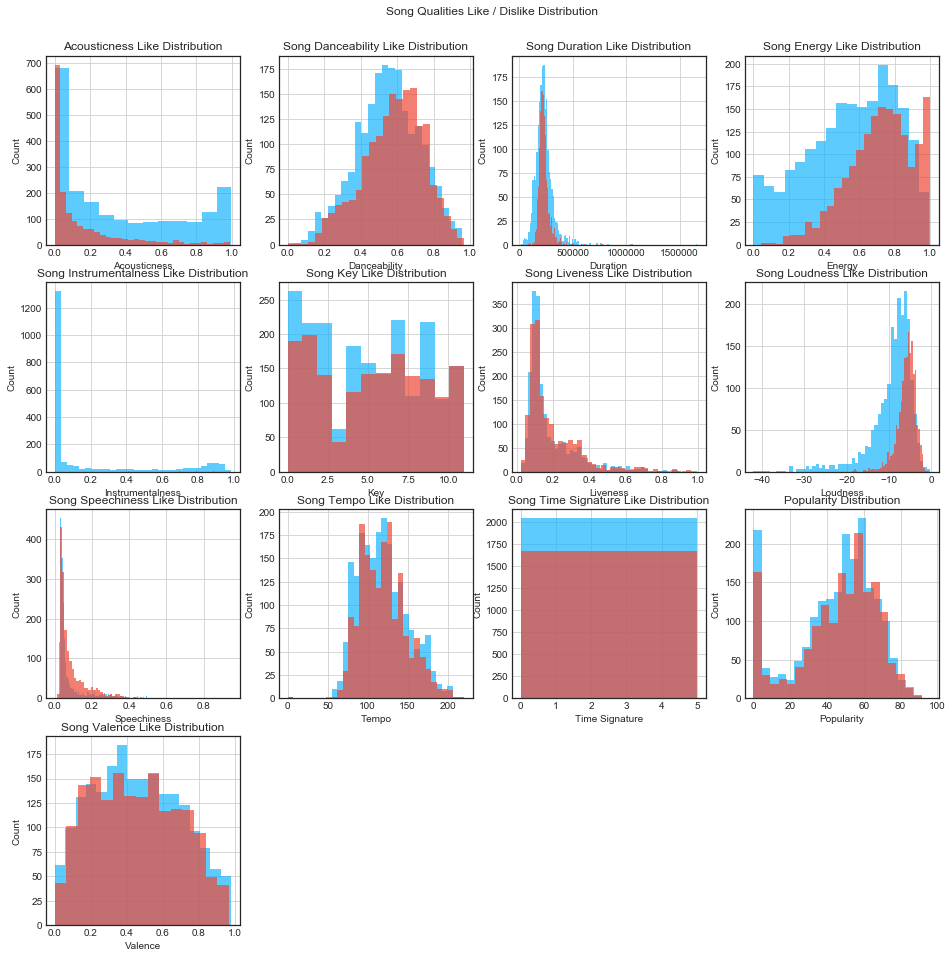

In [158]:
fig = plt.figure(figsize=(16,16))
figure_title = "Song Qualities Like / Dislike Distribution"
plt.title(figure_title, y=1.04)
plt.axis('off')

# 1. Acousticness
ax = fig.add_subplot(441)
ax.set_xlabel('Acousticness')
ax.set_ylabel('Count')
ax.set_title('Acousticness Like Distribution')
good_acousticness.hist(alpha=0.7, bins='auto', label='positive')
ax = fig.add_subplot(441)
bad_acousticness.hist(alpha=0.7, bins='auto', label='negative')

# 2. Danceability
ax = fig.add_subplot(442)
ax.set_xlabel('Danceability')
ax.set_ylabel('Count')
ax.set_title('Song Danceability Like Distribution')
good_dance.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(442)
bad_dance.hist(alpha= 0.7, bins='auto', label='negative')

# 3. Duration_ms
ax = fig.add_subplot(443)
ax.set_xlabel('Duration')
ax.set_ylabel('Count')
ax.set_title('Song Duration Like Distribution')
good_duration.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(443)
bad_duration.hist(alpha= 0.7, bins='auto', label='negative')

# 4. Energy
ax = fig.add_subplot(444)
ax.set_xlabel('Energy')
ax.set_ylabel('Count')
ax.set_title('Song Energy Like Distribution')
good_energy.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(444)
bad_energy.hist(alpha= 0.7, bins='auto', label='negative')

# 5. Instrumentalness
ax = fig.add_subplot(445)
ax.set_xlabel('Instrumentalness')
ax.set_ylabel('Count')
ax.set_title('Song Instrumentalness Like Distribution')
good_instrumentalness.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(445)
bad_instrumentalness.hist(alpha= 0.7, bins='auto', label='negative')

# 6. Key
ax = fig.add_subplot(446)
ax.set_xlabel('Key')
ax.set_ylabel('Count')
ax.set_title('Song Key Like Distribution')
good_key.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(446)
bad_key.hist(alpha= 0.7, bins='auto', label='negative')

# 7. Liveness
ax = fig.add_subplot(447)
ax.set_xlabel('Liveness')
ax.set_ylabel('Count')
ax.set_title('Song Liveness Like Distribution')
good_live.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(447)
bad_live.hist(alpha= 0.7, bins='auto', label='negative')

# 8. Loudness
ax = fig.add_subplot(448)
ax.set_xlabel('Loudness')
ax.set_ylabel('Count')
ax.set_title('Song Loudness Like Distribution')
good_loudness.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(448)
bad_loudness.hist(alpha= 0.7, bins='auto', label='negative')

# 9. Speechiness
ax = fig.add_subplot(449)
ax.set_xlabel('Speechiness')
ax.set_ylabel('Count')
ax.set_title('Song Speechiness Like Distribution')
good_speechiness.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(449)
bad_speechiness.hist(alpha= 0.7, bins='auto', label='negative')

# 10. Tempo
ax = fig.add_subplot(4,4,10)
ax.set_xlabel('Tempo')
ax.set_ylabel('Count')
ax.set_title('Song Tempo Like Distribution')
good_tempo.hist(alpha=0.7, bins='auto', label='positive')
ax = fig.add_subplot(4,4,10)
bad_tempo.hist(alpha=0.7, bins='auto', label='negative')

# 11. Time Signature
ax = fig.add_subplot(4,4,11)
ax.set_xlabel('Time Signature')
ax.set_ylabel('Count')
ax.set_title('Song Time Signature Like Distribution')
good_time.hist(alpha=0.7, bins='auto', label='positive')
ax = fig.add_subplot(4,4,11)
bad_time.hist(alpha=0.7, bins='auto', label='negative')

# 12. Popularity
ax = fig.add_subplot(4,4,12)
ax.set_xlabel('Popularity')
ax.set_ylabel('Count')
ax.set_title('Popularity Distribution')
good_popularity.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(4,4,12)
bad_popularity.hist(alpha= 0.7, bins='auto', label='negative')

# 13 Valence
ax = fig.add_subplot(4,4,13)
ax.set_xlabel('Valence')
ax.set_ylabel('Count')
ax.set_title('Song Valence Like Distribution')
good_valence.hist(alpha= 0.7, bins='auto', label='positive')
ax = fig.add_subplot(4,4,13)
bad_valence.hist(alpha= 0.7, bins='auto', label='negative')


Hmm, not too sure if this data is particularly useful. But I can see a trend of liking quiter, lower energy songs with less speechiness, and a higher key.

<a id='classifiers'></a>

### 3. Classifiers/Model Training
***
Jupyter Notebooks are the perfect place to explore and test different algorithms before deciding on a final method for the model. The [SKLearn library](http://scikit-learn.org) is an excellent library for Machine Learning with Python, providing easy to use functions, classes, and algorithms to learn from and predict data. 
Before I can begin, I have to decide what kind of problem I have, a classification or regression problem. The main difference is that classification is about predicting a label and regression is about predicting a quantity. It isn't difficult to see that I have a classification problem, I'm trying to label songs I like vs. songs I hate.
I'll be testing different Classifiers, possibly Clustering, and a Neural Network Model. The Classifiers and Neural Network Model are a type of Supervised Learning, while Clustering is a type of Unsupervised Learning. The one that gives me better results will be used in the final model Alexa calls upon.

I'll begin by splitting my data into different sets

In [47]:
# split the data up into training sets and test sets 
train, test = train_test_split(trainingData, test_size = 0.15)

# The labels I'll be using for supervised learning, I have removed the features that are much too similar on the graphs
features = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness","loudness","speechiness","time_signature"]


# Split the data into x and y test and train sets to feed them into classifiers
x_train = train[features]
y_train = train["target"]

x_test = test[features]
y_test = test["target"]

<a id='dt'></a>

#### 3a. Decision Tree Classifier 
***
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

/Users/Chris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


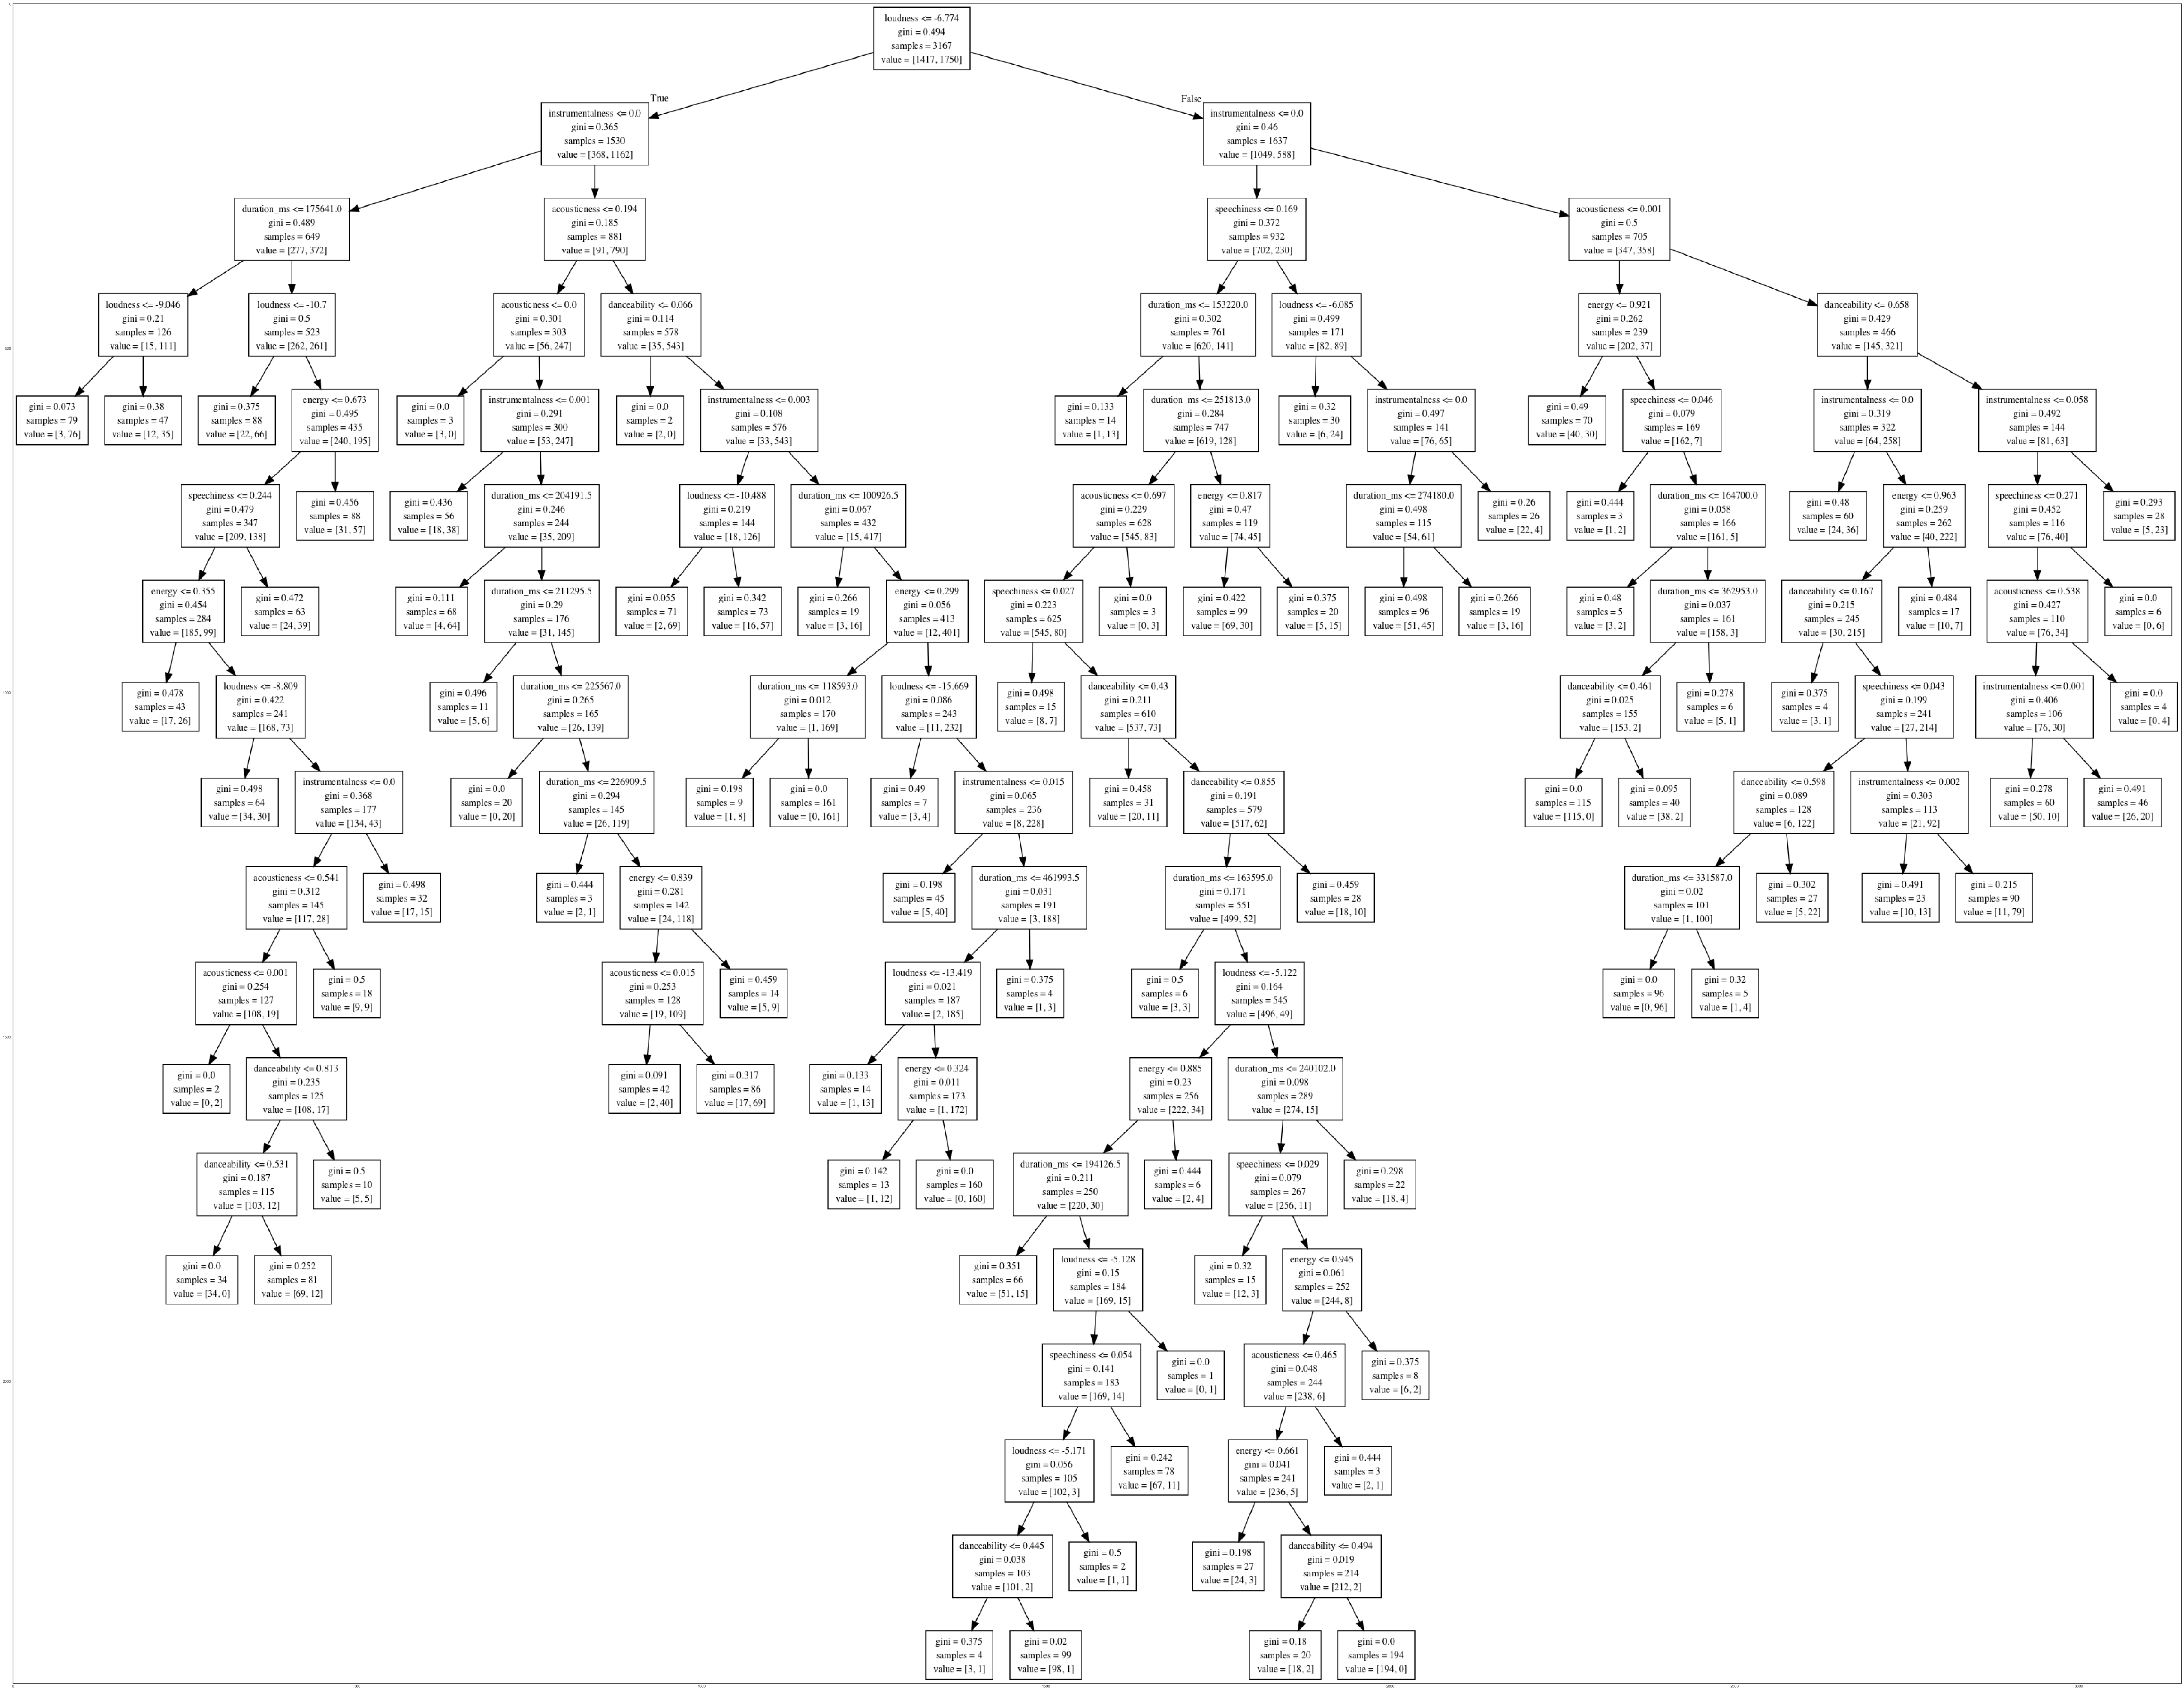

In [48]:
t = DecisionTreeClassifier(min_samples_split=100)
dt = t.fit(x_train, y_train)

def show_tree(InputTree, features, path):
    f = io.StringIO()
    tree.export_graphviz(InputTree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = misc.imread(path)
    plt.rcParams["figure.figsize"] = (100,100)
    plt.imshow(img)
    
show_tree(dt, features, "dec_tree.png")

In [49]:
y_pred = t.predict(x_test)
score = accuracy_score(y_test, y_pred) * 100
print("Accuracy using Decision Tree: ", round(score, 1), "%")

Accuracy using Decision Tree:  75.8 %


<a id='knn'></a>

#### 3b. K-Neighbors Classifier
***
The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. Being a non-parametric method, it is often successful in classification situations where the decision boundary is very irregular.

In [50]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

knn_predict = knn.predict(x_test)
score = accuracy_score(y_test, knn_predict) * 100
print("Accuracy using K-Neighbors: ",round(score,1), "%")

Accuracy using K-Neighbors:  55.5 %


The K-Neighbors classifier is very inaccurate for my data, so I'll keep checking other classifiers.

<a id='gauss'></a>

#### 3c. Gaussian Process Classifier
***
Gaussian Processes (GP) are a generic supervised learning method designed to solve regression and probabilistic classification problems. The GaussianProcessClassifier implements Gaussian processes (GP) for classification purposes, more specifically for probabilistic classification, where test predictions take the form of class probabilities.

In [106]:
from sklearn.gaussian_process.kernels import RBF

gpc = GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
gpc.fit(x_train, y_train)

gpc_predict = gpc.predict(x_test)
score = accuracy_score(y_test, gpc_predict) * 100
print("Accuracy using a Gaussian Process Classifier: ", round(score,1), "%")

Accuracy using a Gaussian Process Classifier:  50.4 %


<a id='bayes'></a>

#### 3d. Gaussian Naive Bayes Classifier
***
Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of independence between every pair of features. This is the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian

In [52]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

gnb_predict = gnb.predict(x_test)
score = accuracy_score(y_test, gnb_predict) * 100
print("Accuracy using Gaussian Naive Bayes", round(score, 1), "%")

Accuracy using Gaussian Naive Bayes 66.2 %


<a id='ensemble'></a>

#### 3e. Ensemble Methods
***
The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability/robustness over a single estimator.

<a id='bagging'></a>

##### I. Bagging meta-estimator
***
Bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [162]:
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=100, max_features=.8)
bagging.fit(x_train, y_train)

bagging_predict = gnb.predict(x_test)
score = accuracy_score(y_test, bagging_predict) * 100
print("Accuracy using a Bagging meta-estimator with a K-Neighbors Classifier: ", round(score,1),"%")

Accuracy using a Bagging meta-estimator with a K-Neighbors Classifier:  66.2 %


<a id='rf'></a>

##### II.  Random Forest Classifier
***
In random forests each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features.

In [89]:
rf = RandomForestClassifier(max_depth=None, n_estimators = 10, max_features = 1, min_samples_split=25)
rf.fit(x_train, y_train)

rf_predict = rf.predict(x_test)
score = accuracy_score(y_test, rf_predict) * 100
print("Accuracy using a Random Forest Classifier: ", round(score, 1), "%")

Accuracy using a Random Forest Classifier:  79.1 %


<a id=et></a>

##### III. Extremely Randomized Trees Classifier
***
In extremely randomized trees randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias:

In [86]:
et = ExtraTreesClassifier(max_depth=None, n_estimato rs = 10, max_features = 7, min_samples_split=25)
et.fit(x_train, y_train)

et_predict = et.predict(x_test)
score = accuracy_score(y_test, et_predict) * 100
print("Accuracy using an Extremely Randomized Trees Classifier: ", round(score, 1), "%")

Accuracy using an Extremely Randomized Trees Classifier:  79.6 %


<a id='ab'></a>

##### IV. Adaboost Classifier
***
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.

In [101]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=.8)
ada.fit(x_train, y_train)

ada_predict = ada.predict(x_test)
score = accuracy_score(y_test, et_predict) * 100
print("Accuracy using an Adaboost Classifier: ", round(score, 1), "%")

Accuracy using an Adaboost Classifier:  79.6 %


<a id='gb'></a>

##### V. Gradient Tree Boosting Classifier
***
Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems.

In [104]:
gb = GradientBoostingClassifier(n_estimators=100) 
gb.fit(x_train, y_train)

gb_predict = gb.predict(x_test)
score = accuracy_score(y_test, gb_predict) * 100
print("Accuracy using a Gradient Tree Boosting Classifier: ", round(score, 1), "%")

Accuracy using a Gradient Tree Boosting Classifier:  78.5 %


<a id=svm></a>

#### 3f. Support Vector Machine Classifier
***
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

In [111]:
svc = svm.SVC(C=0.025)
svc.fit(x_train, y_train)

svc_predict = svc.predict(x_test)
score = accuracy_score(y_test, svc_predict) * 100
print("Accuracy using a C-Support Vector Classifier: ", round(score, 1), "%")

Accuracy using a C-Support Vector Classifier:  53.0 %


In [109]:
lsvc = svm.LinearSVC(C=0.025)

lsvc.fit(x_train, y_train)

lsvc_predict = svc.predict(x_test)
score = accuracy_score(y_test, lsvc_predict) * 100
print("Accuracy using a Linear C-Support Vector Classifier: ", round(score, 1), "%")

Accuracy using a Linear C-Support Vector Classifier:  59.4 %


<a id='qda'></a>

#### 3g. Quadratic Discriminant Analysis Classifier
***
This classifier is attractive because it has closed-form solutions that can be easily computed, are inherently multiclass, have proven to work well in practice and have no hyperparameters to tune.

In [112]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)
qda_pred = qda.predict(x_test)
score = accuracy_score(y_test, qda_pred)*100
print("Accuracy using Quadratic Discriminant Analysis: ", round(score, 1), "%")

Accuracy using Quadratic Discriminant Analysis:  70.3 %


<a id='cluster'></a>

#### 3h. Clustering Classifier
***
Clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters

In [120]:
k_means = KMeans(n_clusters=2, random_state=0)
k_means.fit(x_train, y_train)
predicted= k_means.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Kmeans Clustering: ", round(score, 1), "%")

Accuracy using Kmeans Clustering:  53.1 %


<a id='mlp'></a>

#### 3i. Multi-layer Perceptron
***
Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function by training on a dataset. Given a set of features X = {x_1, x_2, ..., x_m} and a target y, it can learn a non-linear function approximator for either classification or regression.

In [125]:
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, learning_rate='adaptive')
mlp.fit(x_train, y_train)
mlp_pred = mlp.predict(x_test)
score = accuracy_score(y_test, mlp_pred) * 100
print("Accuracy using mlp Tree: ", round(score, 1), "%")

Accuracy using mlp Tree:  53.0 %


<a id='res'></a>

#### 3j. Results
***
After playing around with a bunch of classifiers and algorithms, I've found that I get the best results from tha Adaboost Classifier and the Extremeley Randomized Tree Classifier. Going forward, I'll use one of these for more testing and maybe even the final model. I should eventually come back to the notebook and tweak the the hyperparameters for the various classifiers and see if I can get better results. 80% is not too bad though, given the limited data anaylsis I had access to. What would improve the data analysis is having access to total amount of time played, amount of time skipped, and raw audio waves.

<a id='test'></a>

### 4. Testing 
***
Now that I've chosen the classifier, I'm going to test it on one of Spotify's playlist. I'll be using the Global Top 50 playlist to get a good mix of popular music from around the world right now. This is a good choice because I usually don't like every single song in the Top 50, especially the pop songs.

In [148]:
# Global Top 50
testing_playlist = sp.user_playlist("spotifycharts", "37i9dQZEVXbMDoHDwVN2tF")

# Get the tracks from the results
new_playlist_tracks = testing_playlist["tracks"]

# Get the actual songs themselves from the tracks
new_playlist_songs = new_playlist_tracks["items"]

# Again, Spotify only returns 50 at a time
while new_playlist_tracks["next"]:
    new_playlist_tacks = sp.next(new_playlist_tracks)
    for song in new_playlist_tracks["items"]:
        new_playlist_songs.append(song)

# Save the ID's to get the audio features
new_playlist_song_ids = [] 
for i in range(len(new_playlist_songs)):
    new_playlist_song_ids.append(new_playlist_songs[i]['track']['id'])
    
new_playlist_features = []
j= 0;

# Get the audio features and store some information in a track array for easy access later
for i in range(0,len(new_playlist_song_ids),50):
    audio_features = sp.audio_features(new_playlist_song_ids[i:i+50])
    for track in audio_features:
        track['song_title'] = new_playlist_songs[j]['track']['name']
        track['artist'] = new_playlist_songs[j]['track']['artists'][0]['name']
        j = j + 1
        new_playlist_features.append(track)

# panda, panda, panda panda panda panda
playlistToLookAtFeatures = pd.DataFrame(new_playlist_features)

# Print all the songs in the Top 50 so I can see what I'm working with
print("All songs in the playlist: ")
print("---------------------------")
for i in range(len(playlistToLookAtFeatures)):
    print("Song: " + playlistToLookAtFeatures["song_title"][i] + ", By: "+ playlistToLookAtFeatures["artist"][i])
print("Total Songs: 50\n")

# Get a prediction of the songs I'd like in this playlist
prediction = et.predict(playlistToLookAtFeatures[features])
likedSongs = 0
i = 0
print("Songs in the playlist I'll definitely like: ")
print("------------------------------------------")

# For every prediction 
for pred in prediction:
    
    # If I for sure will like the song, print it
    if(pred == 1):
        print ("Song: " + playlistToLookAtFeatures["song_title"][i] + ", By: "+ playlistToLookAtFeatures["artist"][i])
        likedSongs= likedSongs + 1
    i = i +1
print("Total Songs: ", likedSongs)


All songs in the playlist: 
---------------------------
Song: Better Now, By: Post Malone
Song: Psycho, By: Post Malone
Song: Nice For What, By: Drake
Song: Paranoid, By: Post Malone
Song: God's Plan, By: Drake
Song: No Tears Left To Cry, By: Ariana Grande
Song: One Kiss (with Dua Lipa), By: Calvin Harris
Song: rockstar, By: Post Malone
Song: Spoil My Night, By: Post Malone
Song: Rich & Sad, By: Post Malone
Song: Stay, By: Post Malone
Song: FRIENDS, By: Marshmello
Song: Over Now, By: Post Malone
Song: X, By: Nicky Jam
Song: Ball For Me, By: Post Malone
Song: Zack And Codeine, By: Post Malone
Song: Same Bitches, By: Post Malone
Song: I Like It, By: Cardi B
Song: Takin' Shots, By: Post Malone
Song: Call Out My Name, By: The Weeknd
Song: 92 Explorer, By: Post Malone
Song: Freaky Friday (feat. Chris Brown), By: Lil Dicky
Song: Candy Paint, By: Post Malone
Song: Otherside, By: Post Malone
Song: The Middle, By: Zedd
Song: Love Lies (with Normani), By: Khalid
Song: Blame It On Me, By: Post Ma

<a id='conc'></a>

### 5. Conclusion 
***
I'm actually very pleased with the results! While I have a ton of false negatives, I only have 3 false positives. I'd rather the algorithm be much more conservative than liberal with the prediction, so to me, this has been a success. The next step is to take the model out of the Jupyter Notebook and place it in a script on a server for Alexa to call upon and return the result. The Alexa app is actually an Express server on Heroku that'll call upon the script. I'll keep the script connected to the Global Top 50 so that it's constantly being refreshed with differed music and I'll have Alexa select a random song from the results to play for me. Future improvements will be tweaking the hyperparameters and possibly finding a better model and constantly feeding the algorithm new data so that it prediction of my preferences only gets better. I could theoretically create my own database for more anyalytics and information about my listening habits but for now I'll let Spotify handle that.

In [173]:
# A little script to save my model to disk so i dont have to run this again
from tempfile import mkdtemp
savedir = mkdtemp()
import os
modelFile = os.path.join(savedir, 'et.pkl')
trainingDataFile = os.path.join(savedir, 'data.pkl')
import joblib
joblib.dump(et, 'et.pkl')
joblib.dump(trainingData, 'data.pkl')
joblib.dump(features, 'features.pkl')

['features.pkl']